In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#  Load Libraries


# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Time series & statistics
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Load dataset

file_path = "/content/drive/MyDrive/Colab Notebooks/daily-minimum-temperatures-in-me.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (3650, 2)


Date Daily minimum temperatures
0  1/1/1981                       20.7
1  1/2/1981                       17.9
2  1/3/1981                       18.8
3  1/4/1981                       14.6
4  1/5/1981                       15.8

In [ ]:
# Check column names and data types
print("Dataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB
None


In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Date                          0
Daily minimum temperatures    0
dtype: int64


In [ ]:
# Peek columns in case naming differs
print("Columns:", df.columns.tolist())

df_eda = df.copy()


if 'Date' not in df_eda.columns:
    # look for a date-like column
    date_guess = [c for c in df_eda.columns if 'date' in c.lower()][0]
    df_eda.rename(columns={date_guess: 'Date'}, inplace=True)

if 'Temp' not in df_eda.columns:
    # look for a temp-like column
    temp_guess = [c for c in df_eda.columns if 'temp' in c.lower()][0]
    df_eda.rename(columns={temp_guess: 'Temp'}, inplace=True)

# Parse datetime and sort
df_eda['Date'] = pd.to_datetime(df_eda['Date'], errors='coerce')
df_eda = df_eda.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Set Date as index and ensure daily frequency (best-effort)
df_eda = df_eda.set_index('Date')
df_eda = df_eda.asfreq('D')

print("Shape after cleaning/sorting:", df_eda.shape)
print("\nHead:")
print(df_eda.head())
print("\nTail:")
print(df_eda.tail())

# Missing value summary
print("\nMissing values:")
print(df_eda.isna().sum())


Columns: ['Date', 'Daily minimum temperatures']
Shape after cleaning/sorting: (3652, 1)

Head:
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

Tail:
            Temp
Date            
1990-12-27    14
1990-12-28  13.6
1990-12-29  13.5
1990-12-30  15.7
1990-12-31    13

Missing values:
Temp    2
dtype: int64


In [ ]:
# Which dates are missing after asfreq?
missing_dates = df_eda.index[df_eda['Temp'].isna()]
print("Missing dates:", list(missing_dates))
print("Total missing:", df_eda['Temp'].isna().sum())


Missing dates: [Timestamp('1984-12-31 00:00:00'), Timestamp('1988-12-31 00:00:00')]
Total missing: 2


In [ ]:
# Time-based interpolation is ideal for daily temps
df_eda_filled = df_eda.copy()
df_eda_filled['Temp'] = df_eda_filled['Temp'].interpolate(method='time')

# Safety net if any edge NaNs remain
df_eda_filled['Temp'] = df_eda_filled['Temp'].ffill().bfill()

print("Missing after fill:", df_eda_filled['Temp'].isna().sum())


Missing after fill: 0


In [ ]:
# Summary statistics
# Convert Temp column to numeric (coerce errors → NaN)
df_eda['Temp'] = pd.to_numeric(df_eda['Temp'], errors='coerce')

# Fill any missing values from conversion
df_eda['Temp'] = df_eda['Temp'].interpolate(method='time').ffill().bfill()

print("Data type of Temp:", df_eda['Temp'].dtype)
print("Missing values after fix:", df_eda['Temp'].isna().sum())
print("Descriptive statistics for Temp:")
display(df_eda['Temp'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

print("\nExtra Stats:")
print("Mean:", df_eda['Temp'].mean())
print("Median:", df_eda['Temp'].median())
print("Standard Deviation:", df_eda['Temp'].std())
print("Min:", df_eda['Temp'].min())
print("Max:", df_eda['Temp'].max())

print("\nDate range:")
print(df_eda.index.min(), "→", df_eda.index.max())
print("Number of observations:", df_eda['Temp'].shape[0])


Data type of Temp: float64
Missing values after fix: 0
Descriptive statistics for Temp:


count    3652.000000
mean       11.181175
std         4.067777
min         0.000000
1%          2.317000
5%          4.800000
25%         8.300000
50%        11.000000
75%        14.000000
95%        17.845000
99%        21.400000
max        26.300000
Name: Temp, dtype: float64


Extra Stats:
Mean: 11.181174698795179
Median: 11.0
Standard Deviation: 4.067776602353095
Min: 0.0
Max: 26.3

Date range:
1981-01-01 00:00:00 → 1990-12-31 00:00:00
Number of observations: 3652


IQR bounds: -0.25 to 22.55
IQR outliers count: 13

Z-score threshold: 3.0
Z-score outliers count: 10

Top 10 extreme dates by |z|:


Temp
Date            
1982-02-15  26.3
1982-01-20  25.2
1981-01-15  25.0
1981-02-09  25.0
1981-01-18  24.8
1984-11-26  24.3
1987-11-19  24.1
1982-01-17  24.0
1988-12-16  23.9
1988-01-30  23.4

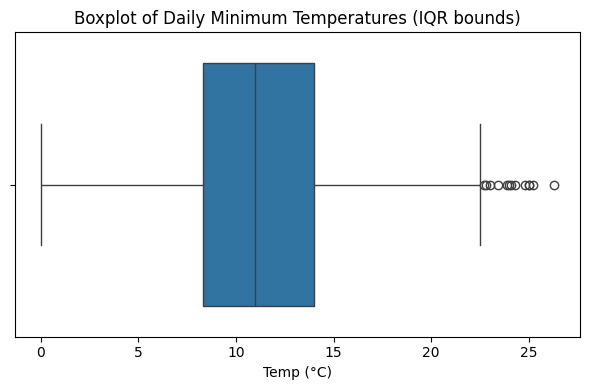

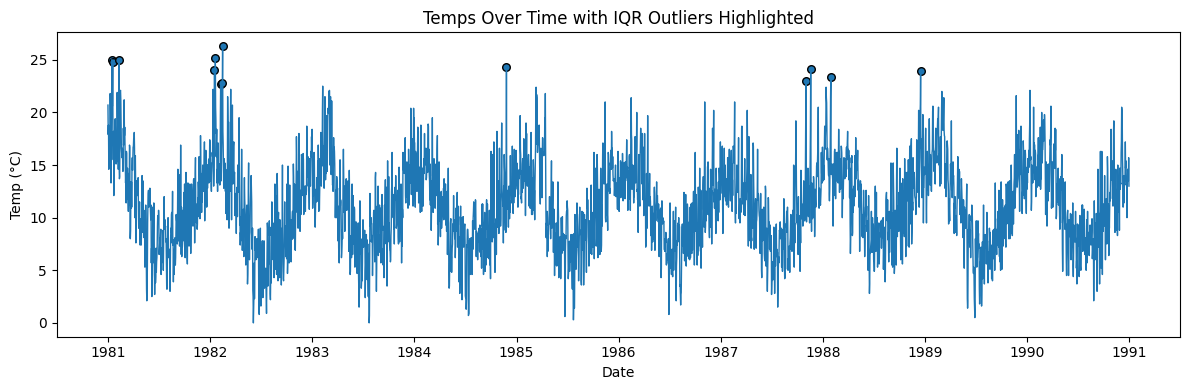

In [ ]:
# Outlier Detection (IQR + z-score) on df_eda['Temp']

s = df_eda['Temp'].dropna()

# --- IQR method ---
q1, q3 = s.quantile([0.25, 0.75])
iqr = q3 - q1
k = 1.5  # IQR multiplier (tune if needed)
lower_iqr = q1 - k * iqr
upper_iqr = q3 + k * iqr
iqr_mask = (s < lower_iqr) | (s > upper_iqr)

# --- z-score method ---
mu = s.mean()
sigma = s.std(ddof=0)
z = (s - mu) / sigma
z_thresh = 3.0
z_mask = z.abs() > z_thresh

# --- Combine & summarize ---
outliers_iqr = s[iqr_mask]
outliers_z   = s[z_mask]

print("IQR bounds:", round(lower_iqr, 3), "to", round(upper_iqr, 3))
print("IQR outliers count:", outliers_iqr.shape[0])

print("\nZ-score threshold:", z_thresh)
print("Z-score outliers count:", outliers_z.shape[0])

# Show dates & values for the top few most extreme by z-score
extreme = z.abs().sort_values(ascending=False).head(10).index
print("\nTop 10 extreme dates by |z|:")
display(df_eda.loc[extreme, ['Temp']])

plt.figure(figsize=(6,4))
sns.boxplot(x=s, orient='h')
plt.title("Boxplot of Daily Minimum Temperatures (IQR bounds)")
plt.xlabel("Temp (°C)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(s.index, s.values, linewidth=1)
plt.scatter(outliers_iqr.index, outliers_iqr.values, marker='o', s=30, edgecolor='k')
plt.title("Temps Over Time with IQR Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel("Temp (°C)")
plt.tight_layout()
plt.show()


In [ ]:
# Recompute IQR bounds from the (already cleaned/interpolated) df_eda['Temp']
s = df_eda['Temp'].dropna()
q1, q3 = s.quantile([0.25, 0.75])
iqr = q3 - q1
k = 1.5  # IQR multiplier (tune to 3.0 for looser capping if desired)
lower_iqr = q1 - k * iqr
upper_iqr = q3 + k * iqr

# Winsorize (cap to IQR bounds)
before = df_eda['Temp'].copy()
df_eda['Temp'] = df_eda['Temp'].clip(lower=lower_iqr, upper=upper_iqr)

n_capped = (before != df_eda['Temp']).sum()
print(f"Capped {n_capped} temperature values to IQR bounds "
      f"[{lower_iqr:.3f}, {upper_iqr:.3f}]")

# Keep the 'filled' copy consistent with handled values
if 'df_eda_filled' in globals():
    df_eda_filled['Temp'] = df_eda['Temp']


Capped 13 temperature values to IQR bounds [-0.250, 22.550]


In [ ]:
# Coerce to numeric (turn any odd strings into NaN), then fill via time interpolation
print("Before:", df_eda_filled['Temp'].dtype)

df_eda_filled['Temp'] = pd.to_numeric(df_eda_filled['Temp'], errors='coerce')
n_new_nans = df_eda_filled['Temp'].isna().sum()
print("NaNs after coercion:", n_new_nans)

if n_new_nans > 0:
    df_eda_filled['Temp'] = df_eda_filled['Temp'].interpolate(method='time').ffill().bfill()

print("After:", df_eda_filled['Temp'].dtype)
print("NaNs now:", df_eda_filled['Temp'].isna().sum())




Before: float64
NaNs after coercion: 0
After: float64
NaNs now: 0


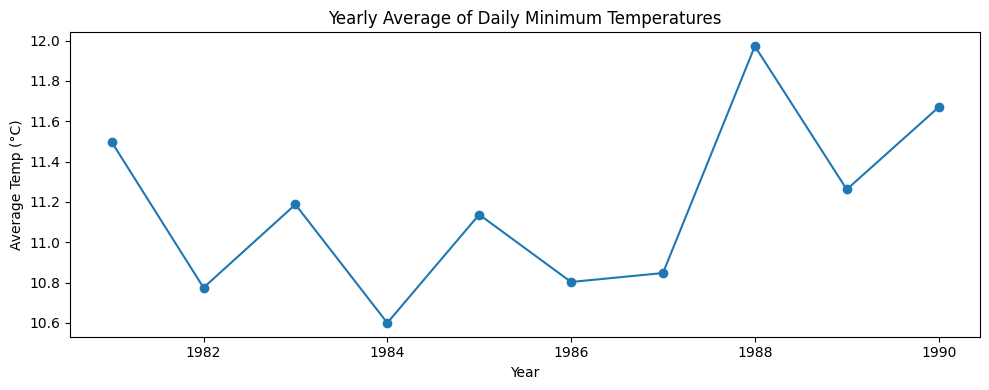

In [ ]:
# Using groupby on the year avoids any resample quirks
yearly_avg = df_eda_filled.groupby(df_eda_filled.index.year)['Temp'].mean()

plt.figure(figsize=(10,4))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linestyle='-')
plt.title("Yearly Average of Daily Minimum Temperatures")
plt.xlabel("Year")
plt.ylabel("Average Temp (°C)")
plt.tight_layout()
plt.show()


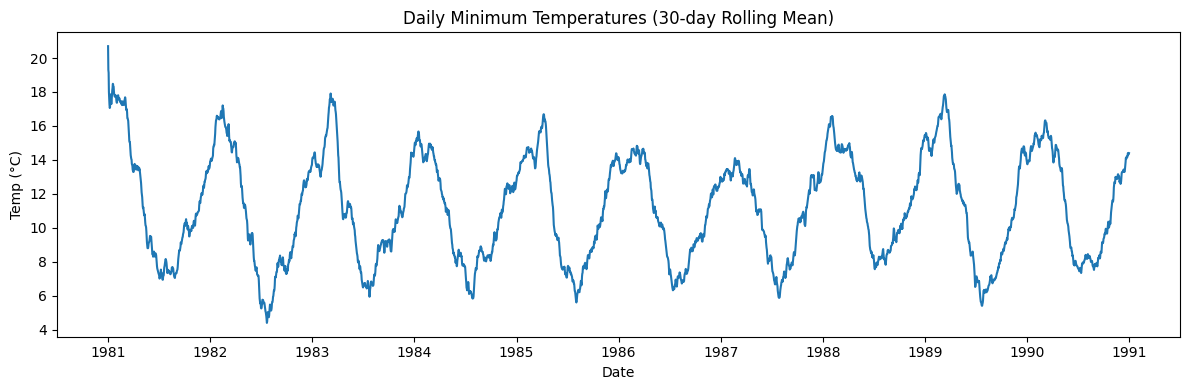

In [ ]:
roll_30 = df_eda_filled['Temp'].rolling(30, min_periods=1).mean()

plt.figure(figsize=(12,4))
plt.plot(roll_30.index, roll_30.values)
plt.title("Daily Minimum Temperatures (30-day Rolling Mean)")
plt.xlabel("Date")
plt.ylabel("Temp (°C)")
plt.tight_layout()
plt.show()


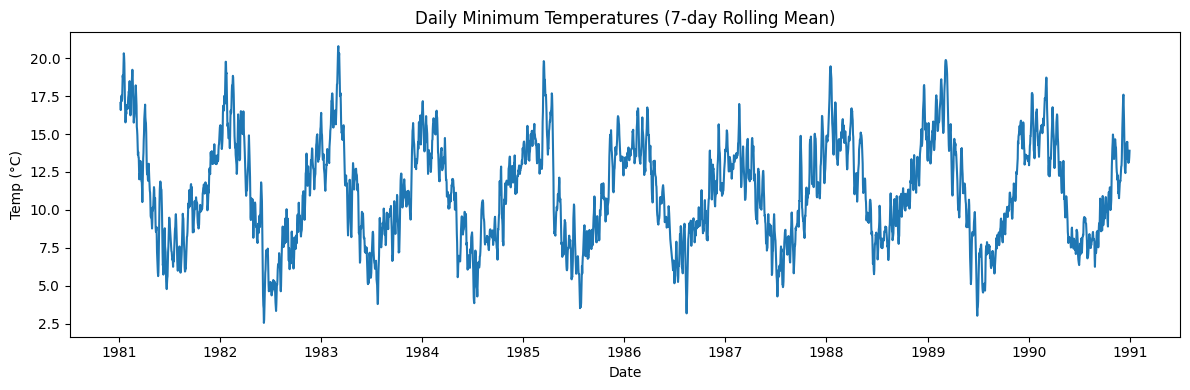

In [ ]:
# -------------------------------
# Phase 1 - Cell 5: Rolling Means
# -------------------------------
roll_7 = df_eda_filled['Temp'].rolling(7).mean()

plt.figure(figsize=(12,4))
plt.plot(roll_7.index, roll_7.values)
plt.title("Daily Minimum Temperatures (7-day Rolling Mean)")
plt.xlabel("Date")
plt.ylabel("Temp (°C)")
plt.tight_layout()
plt.show()


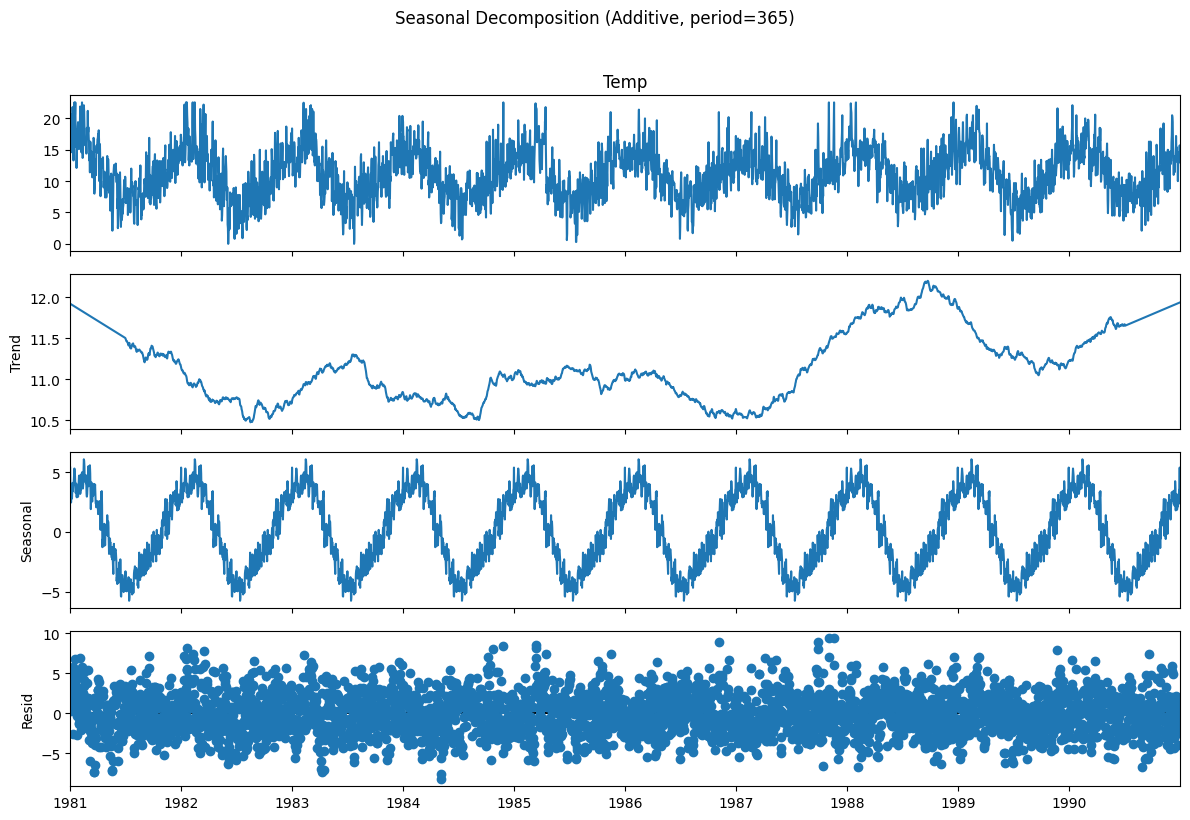

In [ ]:
# Seasonal Decomposition

result = seasonal_decompose(df_eda_filled['Temp'], model='additive', period=365, extrapolate_trend='freq')

fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Seasonal Decomposition (Additive, period=365)", y=1.02)
plt.tight_layout()
plt.show()


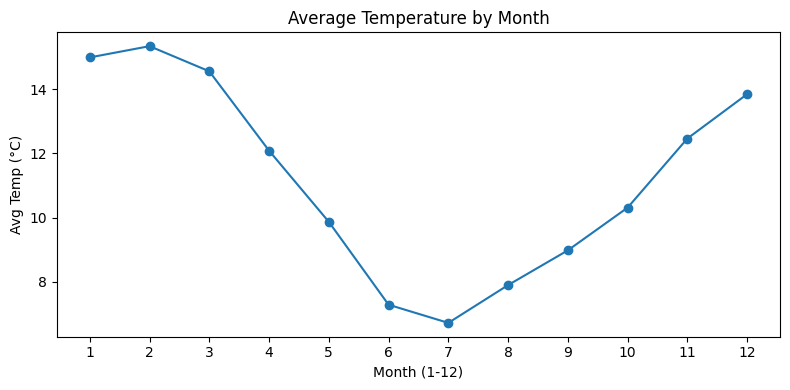

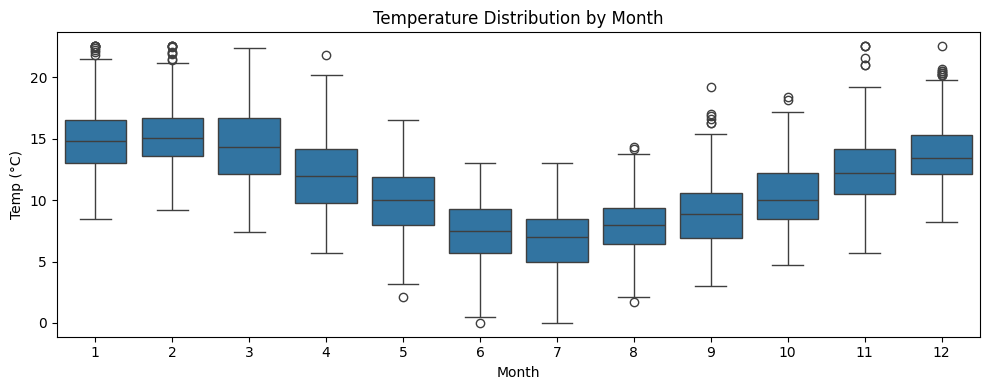

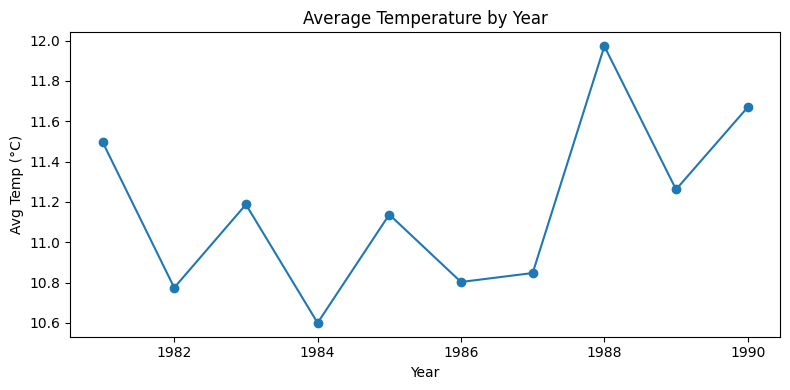

In [ ]:
# Monthly & Yearly Seasonality
tmp = df_eda_filled.copy()
tmp['Year'] = tmp.index.year
tmp['Month'] = tmp.index.month
tmp['Day'] = tmp.index.day

# Monthly average line plot
monthly_avg = tmp.groupby('Month')['Temp'].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title("Average Temperature by Month")
plt.xlabel("Month (1-12)")
plt.ylabel("Avg Temp (°C)")
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()

# Boxplot by month (distribution over years)
plt.figure(figsize=(10,4))
sns.boxplot(x='Month', y='Temp', data=tmp.reset_index())
plt.title("Temperature Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Temp (°C)")
plt.tight_layout()
plt.show()

# Yearly average line (to eyeball long-term drift)
yearly_avg = tmp.groupby('Year')['Temp'].mean()

plt.figure(figsize=(8,4))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title("Average Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Avg Temp (°C)")
plt.tight_layout()
plt.show()


<Figure size 1000x320 with 0 Axes>

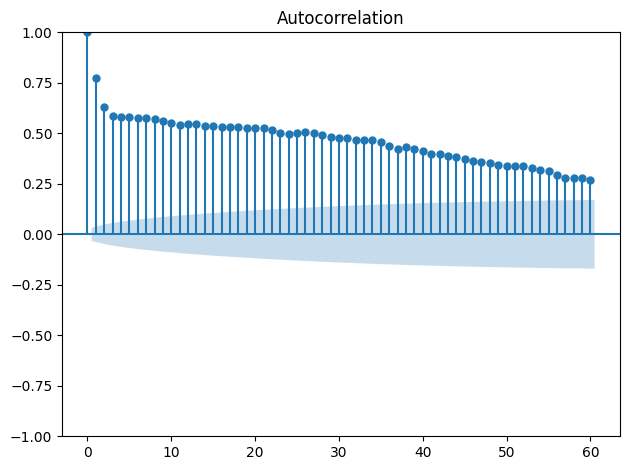

<Figure size 1000x320 with 0 Axes>

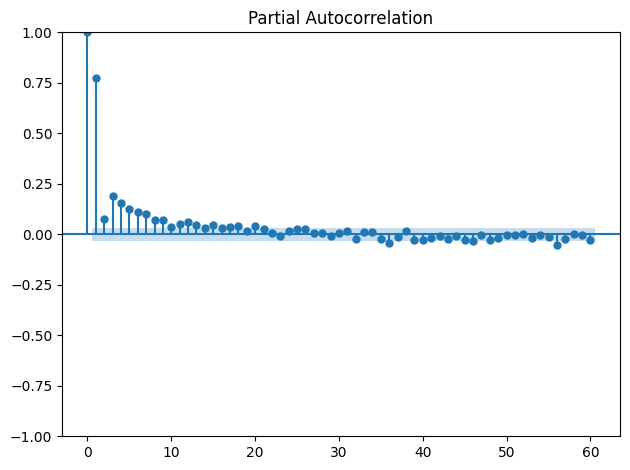

In [ ]:
#  Cell 8: ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,3.2))
plot_acf(df_eda_filled['Temp'], lags=60)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3.2))
plot_pacf(df_eda_filled['Temp'], lags=60, method='ywm')
plt.tight_layout()
plt.show()


In [ ]:
#  Augmented Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller

adf_res = adfuller(df_eda_filled['Temp'])
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])
print("Used lags:", adf_res[2])
print("Number of observations:", adf_res[3])
print("Critical Values:")
for k, v in adf_res[4].items():
    print(f"  {k}: {v:.4f}")

if adf_res[1] < 0.05:
    print("\n Series is likely stationary (reject H0).")
else:
    print("\nℹ Series is likely NON-stationary (fail to reject H0).")


ADF Statistic: -4.413354187998535
p-value: 0.00028108950778641415
Used lags: 20
Number of observations: 3631
Critical Values:
  1%: -3.4322
  5%: -2.8623
  10%: -2.5672

 Series is likely stationary (reject H0).


In [ ]:

# Make a fresh copy for modeling
df_feat = df_eda.copy().reset_index()

# Ensure correct column names
df_feat.rename(columns={"Date": "ds", "Temp": "y"}, inplace=True)

# Extract date features
df_feat["year"] = df_feat["ds"].dt.year
df_feat["month"] = df_feat["ds"].dt.month
df_feat["day"] = df_feat["ds"].dt.day
df_feat["dayofweek"] = df_feat["ds"].dt.dayofweek
df_feat["dayofyear"] = df_feat["ds"].dt.dayofyear
df_feat["weekofyear"] = df_feat["ds"].dt.isocalendar().week.astype(int)

print(df_feat.head())

          ds     y  year  month  day  dayofweek  dayofyear  weekofyear
0 1981-01-01  20.7  1981      1    1          3          1           1
1 1981-01-02  17.9  1981      1    2          4          2           1
2 1981-01-03  18.8  1981      1    3          5          3           1
3 1981-01-04  14.6  1981      1    4          6          4           1
4 1981-01-05  15.8  1981      1    5          0          5           2


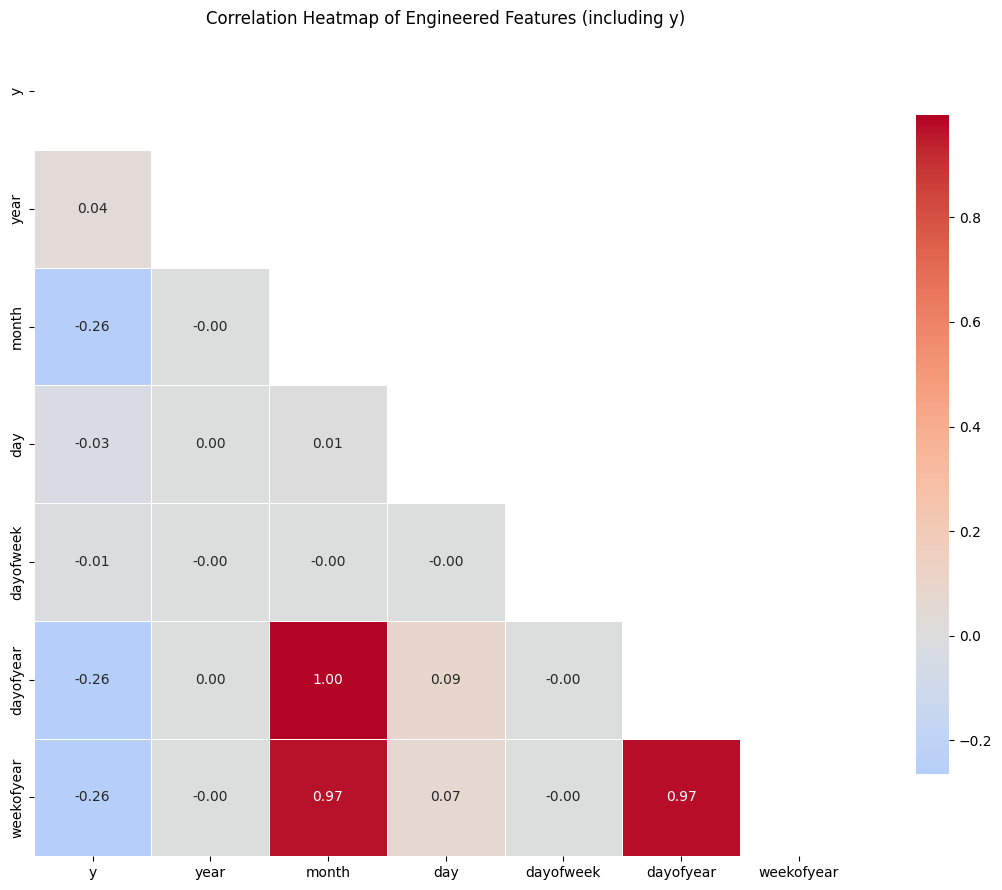

In [ ]:
all_numeric_cols = df_feat.select_dtypes(include=['number']).columns.tolist()
cols_for_corr = [c for c in all_numeric_cols if c in df_feat.columns]

corr = df_feat[cols_for_corr].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,9))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Engineered Features (including y)")
plt.tight_layout()
plt.show()

In [ ]:
# previous 1, 2, 3 days
for lag in [1, 2, 3, 7, 14]:
    df_feat[f"lag_{lag}"] = df_feat["y"].shift(lag)

print(df_feat.head(10))

          ds     y  year  month  day  dayofweek  dayofyear  weekofyear  lag_1  \
0 1981-01-01  20.7  1981      1    1          3          1           1    NaN   
1 1981-01-02  17.9  1981      1    2          4          2           1   20.7   
2 1981-01-03  18.8  1981      1    3          5          3           1   17.9   
3 1981-01-04  14.6  1981      1    4          6          4           1   18.8   
4 1981-01-05  15.8  1981      1    5          0          5           2   14.6   
5 1981-01-06  15.8  1981      1    6          1          6           2   15.8   
6 1981-01-07  15.8  1981      1    7          2          7           2   15.8   
7 1981-01-08  17.4  1981      1    8          3          8           2   15.8   
8 1981-01-09  21.8  1981      1    9          4          9           2   17.4   
9 1981-01-10  20.0  1981      1   10          5         10           2   21.8   

   lag_2  lag_3  lag_7  lag_14  
0    NaN    NaN    NaN     NaN  
1    NaN    NaN    NaN     NaN  
2   20.7 

In [ ]:
#  Rolling window stats

df_feat["roll_mean_7"] = df_feat["y"].rolling(window=7).mean()
df_feat["roll_std_7"] = df_feat["y"].rolling(window=7).std()

df_feat["roll_mean_30"] = df_feat["y"].rolling(window=30).mean()
df_feat["roll_std_30"] = df_feat["y"].rolling(window=30).std()

print(df_feat.head(15))


           ds      y  year  month  day  dayofweek  dayofyear  weekofyear  \
0  1981-01-01  20.70  1981      1    1          3          1           1   
1  1981-01-02  17.90  1981      1    2          4          2           1   
2  1981-01-03  18.80  1981      1    3          5          3           1   
3  1981-01-04  14.60  1981      1    4          6          4           1   
4  1981-01-05  15.80  1981      1    5          0          5           2   
5  1981-01-06  15.80  1981      1    6          1          6           2   
6  1981-01-07  15.80  1981      1    7          2          7           2   
7  1981-01-08  17.40  1981      1    8          3          8           2   
8  1981-01-09  21.80  1981      1    9          4          9           2   
9  1981-01-10  20.00  1981      1   10          5         10           2   
10 1981-01-11  16.20  1981      1   11          6         11           2   
11 1981-01-12  13.30  1981      1   12          0         12           3   
12 1981-01-1

In [ ]:
# Clean final dataset

df_feat = df_feat.dropna().reset_index(drop=True)

print("Final feature dataset shape:", df_feat.shape)
print(df_feat.head())


Final feature dataset shape: (3623, 17)
          ds     y  year  month  day  dayofweek  dayofyear  weekofyear  lag_1  \
0 1981-01-30  15.1  1981      1   30          4         30           5   15.5   
1 1981-01-31  15.4  1981      1   31          5         31           5   15.1   
2 1981-02-01  15.3  1981      2    1          6         32           5   15.4   
3 1981-02-02  18.8  1981      2    2          0         33           6   15.3   
4 1981-02-03  21.9  1981      2    3          1         34           6   18.8   

   lag_2  lag_3  lag_7  lag_14  roll_mean_7  roll_std_7  roll_mean_30  \
0   17.2   19.4   14.4   20.70    16.914286    1.620112     17.633333   
1   15.5   17.2   16.0   20.60    16.828571    1.690872     17.456667   
2   15.1   15.5   16.5   22.55    16.657143    1.787789     17.370000   
3   15.4   15.1   18.7   17.70    16.671429    1.807129     17.370000   
4   15.3   15.4   19.4   15.50    17.028571    2.536214     17.613333   

   roll_std_30  
0     2.764689  


In [ ]:
# Train/Test Split

split_idx = int(len(df_feat) * 0.8)

train = df_feat.iloc[:split_idx]
test  = df_feat.iloc[split_idx:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Define X and y
feature_cols = [c for c in df_feat.columns if c not in ["ds", "y"]]
X_train, y_train = train[feature_cols], train["y"]
X_test, y_test   = test[feature_cols], test["y"]

print("Feature columns:", feature_cols[:10], "...")


Train shape: (2898, 17)
Test shape: (725, 17)
Feature columns: ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'lag_1', 'lag_2', 'lag_3', 'lag_7'] ...


In [ ]:
#Helpers

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

def print_metrics(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"\n[{label}]")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R² : {r2:.4f}")
    return {"MAE": mae, "MSE": mse, "R2": r2}

# time-series cross-validation (preserves order)
tscv = TimeSeriesSplit(n_splits=5)


In [ ]:
#  Baseline Linear Regression

lin_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

lin_pipe.fit(X_train, y_train)

# Predictions
y_pred_lin = lin_pipe.predict(X_test)

# Metrics
print("\n[Baseline Linear Regression]")
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("MSE:", mean_squared_error(y_test, y_pred_lin))
print("R² :", r2_score(y_test, y_pred_lin))



[Baseline Linear Regression]
MAE: 1.5692980339284723
MSE: 3.9074834502873492
R² : 0.7672634469545134


In [ ]:
#  Baseline Random Forest

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Metrics
print("\n[Baseline Random Forest]")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("R² :", r2_score(y_test, y_pred_rf))



[Baseline Random Forest]
MAE: 1.5304485057471262
MSE: 3.7862303129118775
R² : 0.7744854960297676


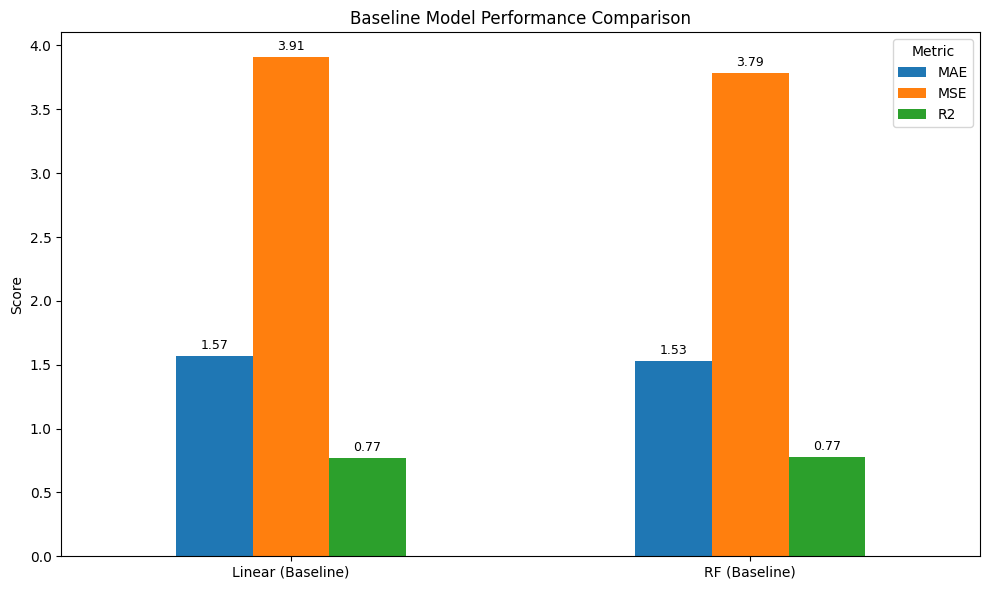

MAE       MSE        R2
Linear (Baseline)  1.569298  3.907483  0.767263
RF (Baseline)      1.530449  3.786230  0.774485

In [ ]:
# Model Comparison

# Collect baseline results
baseline_results = {
    "Linear (Baseline)": {
        "MAE": mean_absolute_error(y_test, y_pred_lin),
        "MSE": mean_squared_error(y_test, y_pred_lin),
        "R2": r2_score(y_test, y_pred_lin)
    },
    "RF (Baseline)": {
        "MAE": mean_absolute_error(y_test, y_pred_rf),
        "MSE": mean_squared_error(y_test, y_pred_rf),
        "R2": r2_score(y_test, y_pred_rf)
    }
}

# Convert to DataFrame
baseline_df = pd.DataFrame(baseline_results).T

# Plot
ax = baseline_df.plot(kind="bar", figsize=(10,6))
plt.title("Baseline Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, rotation=0, xytext=(0,3),
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Show table also
display(baseline_df)


In [ ]:
pred_df = test[["ds", "y"]].copy()
pred_df["y_pred_lin"] = y_pred_lin
pred_df["y_pred_rf"]  = y_pred_rf

print("Preview of predictions:")
display(pred_df.head())

print("\n=== Baseline Comparison ===")
print("Linear vs Random Forest results shown above.")


Preview of predictions:


ds     y  y_pred_lin  y_pred_rf
2898 1989-01-06   9.5   12.046207    11.3770
2899 1989-01-07  12.2   12.703840    12.5350
2900 1989-01-08  15.7   15.417399    14.1880
2901 1989-01-09  16.3   16.163573    16.4995
2902 1989-01-10  13.6   13.968023    14.0505


=== Baseline Comparison ===
Linear vs Random Forest results shown above.


In [ ]:
# Tune Random Forest

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf_gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,  # smaller CV to save time
    n_jobs=-1,
    verbose=0
)

rf_gs.fit(X_train, y_train)

print("Best RF Params:", rf_gs.best_params_)

y_pred_rf_tuned = rf_gs.predict(X_test)

rf_tuned_results = {
    "MAE": mean_absolute_error(y_test, y_pred_rf_tuned),
    "MSE": mean_squared_error(y_test, y_pred_rf_tuned),
    "R2": r2_score(y_test, y_pred_rf_tuned)
}

print("\n[Tuned Random Forest]")
print("MAE:", rf_tuned_results["MAE"])
print("MSE:", rf_tuned_results["MSE"])
print("R² :", rf_tuned_results["R2"])

Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}

[Tuned Random Forest]
MAE: 1.5206952658756707
MSE: 3.7105232370345687
R² : 0.778994741969003


In [ ]:
results = {
    "Linear (Baseline)": {
        "MAE": mean_absolute_error(y_test, y_pred_lin),
        "MSE": mean_squared_error(y_test, y_pred_lin),
        "R2": r2_score(y_test, y_pred_lin)
    },
    "RF (Baseline)": {
        "MAE": mean_absolute_error(y_test, y_pred_rf),
        "MSE": mean_squared_error(y_test, y_pred_rf),
        "R2": r2_score(y_test, y_pred_rf)
    },
    "RF (Tuned)": rf_tuned_results
}

results_df = pd.DataFrame(results).T
display(results_df)

# Pick the best model (highest R², lowest errors)
best_model_name = results_df['R2'].idxmax()
print(f"\n Best Model Selected: {best_model_name}")


MAE       MSE        R2
Linear (Baseline)  1.569298  3.907483  0.767263
RF (Baseline)      1.530449  3.786230  0.774485
RF (Tuned)         1.520695  3.710523  0.778995


 Best Model Selected: RF (Tuned)


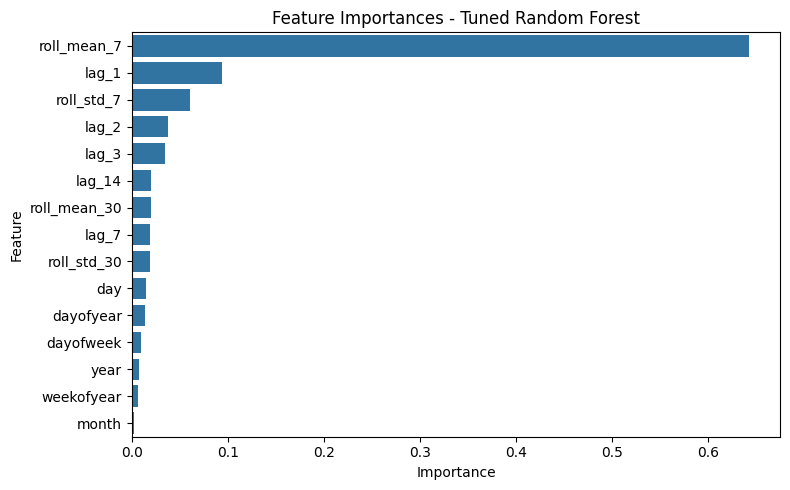

Feature  Importance
11   roll_mean_7    0.642402
6          lag_1    0.093358
12    roll_std_7    0.060647
7          lag_2    0.037356
8          lag_3    0.034746
10        lag_14    0.019784
13  roll_mean_30    0.019730
9          lag_7    0.019282
14   roll_std_30    0.018654
2            day    0.015018
4      dayofyear    0.013855
3      dayofweek    0.009783
0           year    0.007619
5     weekofyear    0.006088
1          month    0.001679

In [ ]:
#  Feature Importance (Random Forest)

best_rf = rf_gs.best_estimator_
importances = best_rf.feature_importances_
features = X_train.columns

fi_df = pd.DataFrame({"Feature": features, "Importance": importances})
fi_df = fi_df.sort_values("Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Feature Importances - Tuned Random Forest")
plt.tight_layout()
plt.show()

display(fi_df)


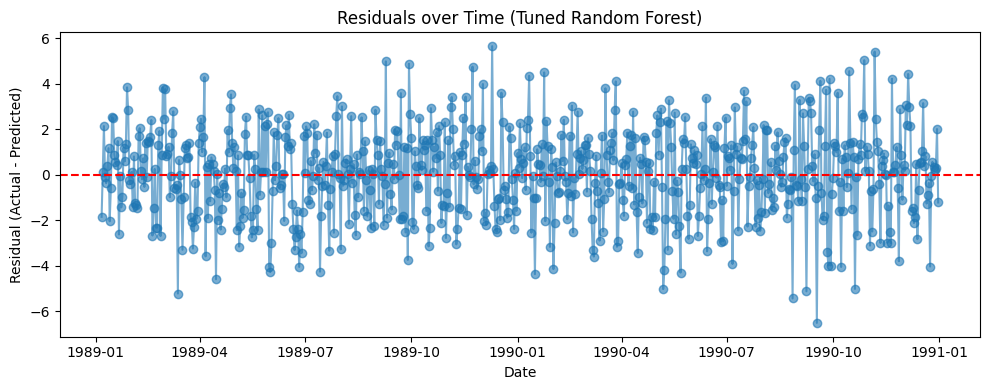

Residuals Summary:


count    725.000000
mean       0.057528
std        1.926742
min       -6.513489
25%       -1.264331
50%        0.135415
75%        1.311339
max        5.657690
Name: y, dtype: float64

In [ ]:
# Residuals = Actual - Predicted
residuals = y_test - y_pred_rf_tuned

plt.figure(figsize=(10,4))
plt.plot(test["ds"], residuals, marker='o', linestyle='-', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals over Time (Tuned Random Forest)")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

print("Residuals Summary:")
display(residuals.describe())

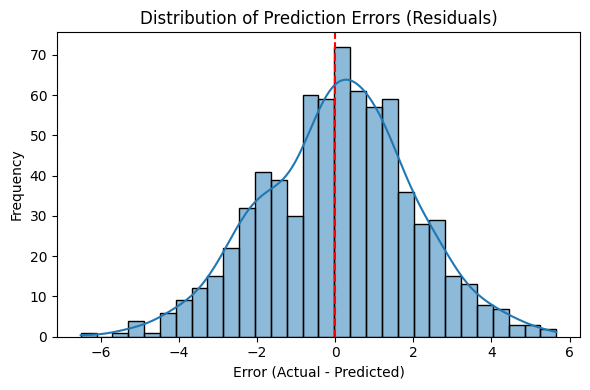

In [ ]:
# Error Distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


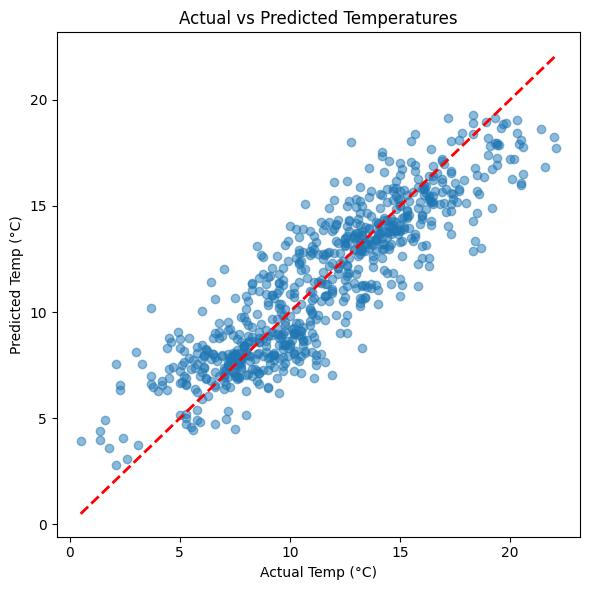

In [ ]:
# Actual vs Predicted Scatter
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.title("Actual vs Predicted Temperatures")
plt.xlabel("Actual Temp (°C)")
plt.ylabel("Predicted Temp (°C)")
plt.tight_layout()
plt.show()


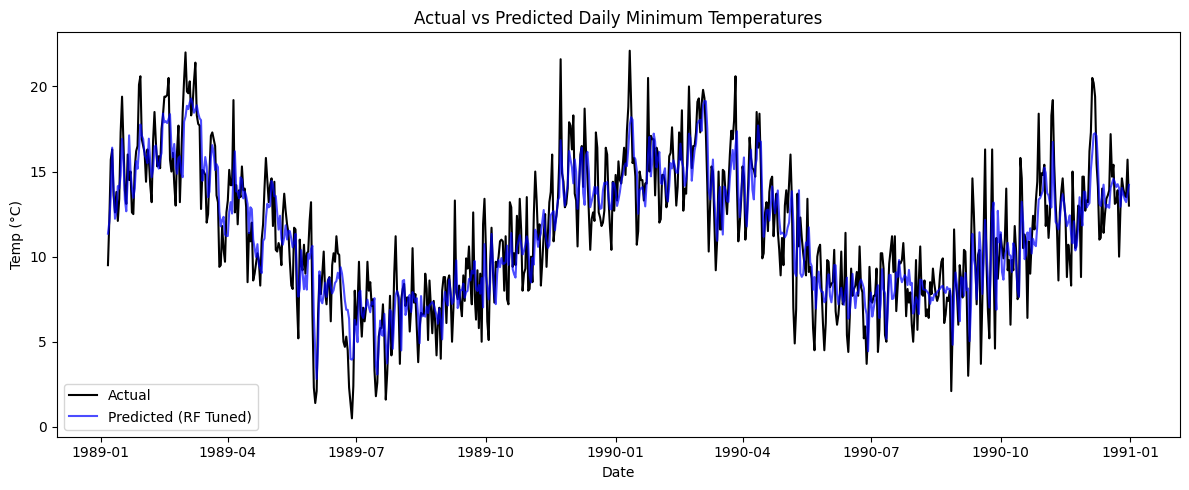

In [ ]:
# Time Series Comparison
plt.figure(figsize=(12,5))
plt.plot(test["ds"], y_test, label="Actual", color="black")
plt.plot(test["ds"], y_pred_rf_tuned, label="Predicted (RF Tuned)", color="blue", alpha=0.7)
plt.title("Actual vs Predicted Daily Minimum Temperatures")
plt.xlabel("Date")
plt.ylabel("Temp (°C)")
plt.legend()
plt.tight_layout()
plt.show()
